In [205]:
import numpy as np
from collections import Counter

def data_loader():
    # load data
    with open('train','r') as file:
        train_data = file.read().split('\n')[:-1]
    with open('test','r') as file:
        test_data = file.read().split('\n')[:-1]
    return train_data, test_data

def parser(datum):
    # extract labels and words
    email_addr, label, words = datum.split(' ',2)
    words = words.split()
    # transform words into dictionary
    word_dict = dict(zip([words[i] for i in range(0, len(words), 2)], [int(words[i+1]) for i in range(0, len(words), 2)]))
    # transform label into 0, 1
    if label == 'ham':
        label = 0
    elif label == 'spam':
        label = 1
    else:
        raise ValueError
    return label, word_dict

def data_preprocessing(train_data, test_data):
    y_train = np.zeros(len(train_data))
    y_test = np.zeros(len(test_data))
    x_train = []
    x_test = []
    for i, datum in enumerate(train_data):
        label, word_dict = parser(datum)
        y_train[i] = label
        x_train.append(word_dict)
    for i, datum in enumerate(test_data):
        label, word_dict = parser(datum)
        y_test[i] = label
        x_test.append(word_dict)
    return x_train, y_train, x_test, y_test

def compute_empirical_pmf_y(y_train):
    # compte distribution P(y=1), P(y=0)
    p_spam = np.mean(y_train)
    p_ham = 1 - p_spam
    return p_spam, p_ham

def m_estimation_conditional_probability(x_train_frt, y_train, num_vocab, m):
    # compute P(x_j|y=1) and P(x_j|y=0) for j = 1, ..., d
    idx_spam = np.where(y_train == 1)[0]
    idx_ham = np.where(y_train == 0)[0]

    # Number of spam and ham emails
    n_spam = len(idx_spam)
    n_ham = len(idx_ham)

    # Compute prior probabilities for each feature
    p_prior = np.sum(x_train_frt, axis=0) / x_train_frt.shape[0]  # shape (num_vocab,)

    # For each feature, count number of times x_j=1 in spam emails
    k_spam = np.sum(x_train_frt[idx_spam], axis=0)  # shape (num_vocab,)
    # Similarly for ham emails
    k_ham = np.sum(x_train_frt[idx_ham], axis=0)

    # Compute P(x_j=1|y=1) with m-estimation
    p_on_spam_m = (k_spam + m * p_prior) / (n_spam + m)
    p_on_ham_m = (k_ham + m * p_prior) / (n_ham + m)

    return p_on_spam_m, p_on_ham_m
    
def log_estimated_probability(p_spam, p_ham, p_on_spam_m, p_on_ham_m, x_frts):
    # compute log(P(y=1, x_1, x_2,..., x_n)) and log(P(y=0, x_1, x_2,..., x_n))
    # hint: log(P(y, x_1, x_2,..., x_n)) = log(P(y=1)) + log(P(x_1 | y)) + ... + log(P(x_d | y))
    epsilon = 1e-10  # To avoid log(0)
    log_p_spam_prior = np.log(p_spam + epsilon)
    log_p_ham_prior = np.log(p_ham + epsilon)

    log_p_on_spam_m = np.log(p_on_spam_m + epsilon)
    log_one_minus_p_on_spam_m = np.log(1 - p_on_spam_m + epsilon)
    log_p_on_ham_m = np.log(p_on_ham_m + epsilon)
    log_one_minus_p_on_ham_m = np.log(1 - p_on_ham_m + epsilon)

    # Compute log probabilities
    log_p_spam = (
        log_p_spam_prior
        + x_frts @ log_p_on_spam_m
        + (1 - x_frts) @ log_one_minus_p_on_spam_m
    )
    log_p_ham = (
        log_p_ham_prior
        + x_frts @ log_p_on_ham_m
        + (1 - x_frts) @ log_one_minus_p_on_ham_m
    )

    return log_p_spam, log_p_ham
    
def accuarcy(y_true, y_pred):
    # calculate accuracy
    return np.mean(y_true == y_pred)

## Load and preprocess data

In [208]:
from sklearn.feature_extraction import DictVectorizer
# load data
train_data, test_data = data_loader()

# extract labels to 0,1 and features to dicticnary
x_train, y_train, x_test, y_test = data_preprocessing(train_data, test_data)

# transform word dicts to feature vectors
vectorizer = DictVectorizer(sparse=False)
x_train_frt = vectorizer.fit_transform(x_train)
x_test_frt = vectorizer.transform(x_test)
print(x_train_frt.shape, x_test_frt.shape)

(9000, 1000) (1000, 1000)


### Grid search for the best $m$.

Which $m$ result in the highest accuracy in the test set?

In [210]:
def pipeline(x_train_frt, y_train, x_test_frt, y_test, m):
    p_spam, p_ham = compute_empirical_pmf_y(y_train)
    p_on_spam_m, p_on_ham_m = m_estimation_conditional_probability(x_train_frt, y_train, x_train_frt.shape[1], m)
    log_p_spam, log_p_ham = log_estimated_probability(p_spam, p_ham, p_on_spam_m, p_on_ham_m, x_test_frt)
    test_pred = (log_p_spam > log_p_ham)
    print(str(m) + ":" + str(accuarcy(y_test, test_pred)))

x_train_frt, x_test_frt = (x_train_frt > 0).astype('int'), (x_test_frt > 0).astype('int')
m_grid = [0, 0.01, 0.1, 1, 10, 100, 1000]
for m in m_grid:
    pipeline(x_train_frt, y_train, x_test_frt, y_test, m)

0:0.928
0.01:0.928
0.1:0.928
1:0.928
10:0.928
100:0.925
1000:0.92



Are all training features binary? True
Are all testing features binary? True
Accuracy: 0.928
Confusion Matrix:
[[353  67]
 [  5 575]]
Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      0.84      0.91       420
        Spam       0.90      0.99      0.94       580

    accuracy                           0.93      1000
   macro avg       0.94      0.92      0.92      1000
weighted avg       0.93      0.93      0.93      1000



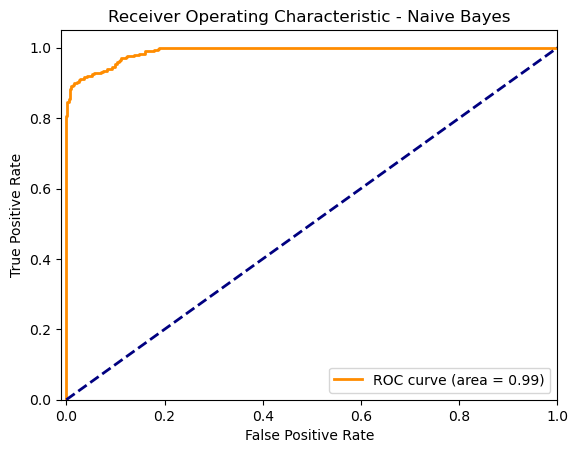

Accuracy: 0.928
Confusion Matrix:
[[353  67]
 [  5 575]]
Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      0.84      0.91       420
        Spam       0.90      0.99      0.94       580

    accuracy                           0.93      1000
   macro avg       0.94      0.92      0.92      1000
weighted avg       0.93      0.93      0.93      1000



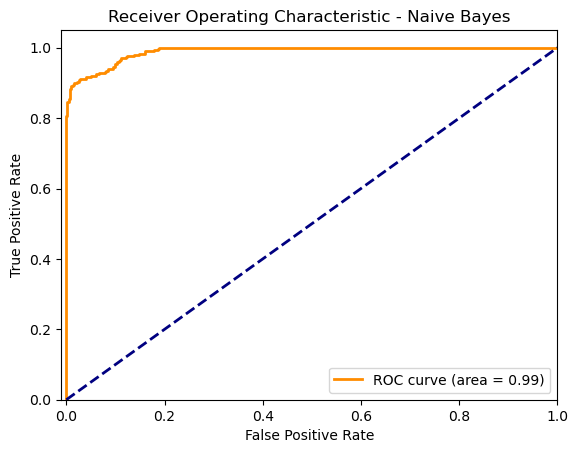

Accuracy: 0.928
Confusion Matrix:
[[353  67]
 [  5 575]]
Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      0.84      0.91       420
        Spam       0.90      0.99      0.94       580

    accuracy                           0.93      1000
   macro avg       0.94      0.92      0.92      1000
weighted avg       0.93      0.93      0.93      1000



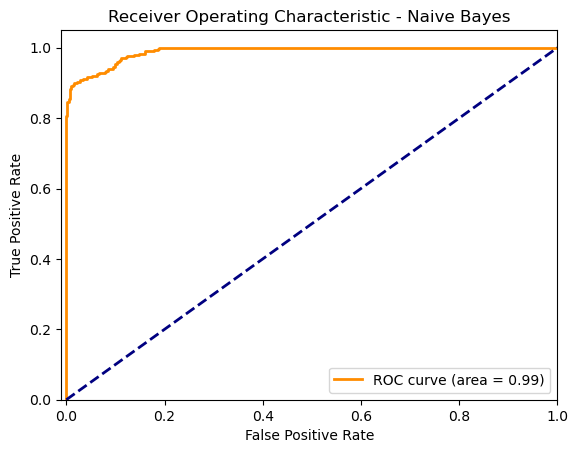

Accuracy: 0.928
Confusion Matrix:
[[353  67]
 [  5 575]]
Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      0.84      0.91       420
        Spam       0.90      0.99      0.94       580

    accuracy                           0.93      1000
   macro avg       0.94      0.92      0.92      1000
weighted avg       0.93      0.93      0.93      1000



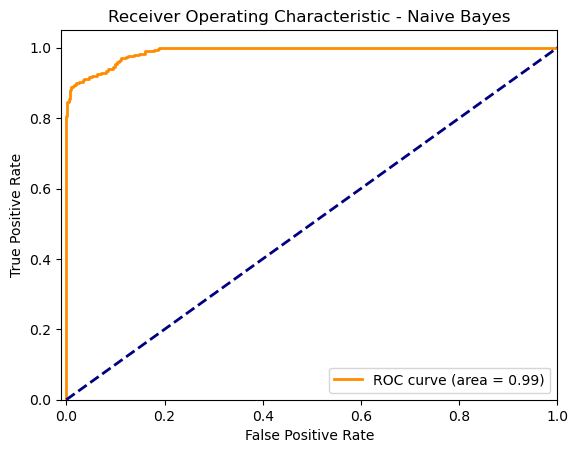

Accuracy: 0.928
Confusion Matrix:
[[353  67]
 [  5 575]]
Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      0.84      0.91       420
        Spam       0.90      0.99      0.94       580

    accuracy                           0.93      1000
   macro avg       0.94      0.92      0.92      1000
weighted avg       0.93      0.93      0.93      1000



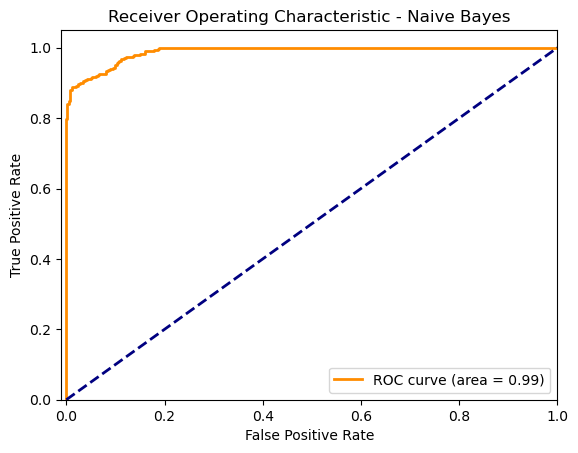

Accuracy: 0.925
Confusion Matrix:
[[351  69]
 [  6 574]]
Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      0.84      0.90       420
        Spam       0.89      0.99      0.94       580

    accuracy                           0.93      1000
   macro avg       0.94      0.91      0.92      1000
weighted avg       0.93      0.93      0.92      1000



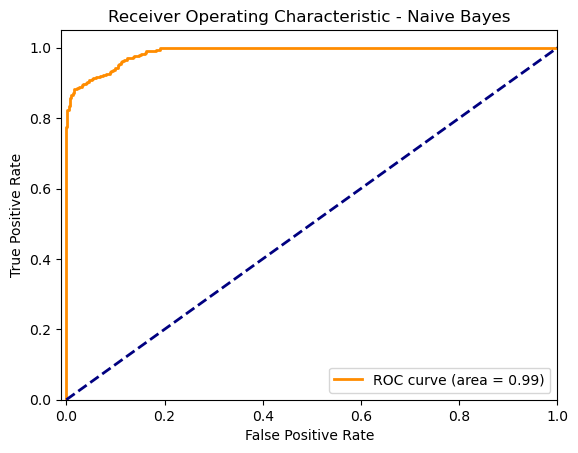

Accuracy: 0.920
Confusion Matrix:
[[347  73]
 [  7 573]]
Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      0.83      0.90       420
        Spam       0.89      0.99      0.93       580

    accuracy                           0.92      1000
   macro avg       0.93      0.91      0.92      1000
weighted avg       0.93      0.92      0.92      1000



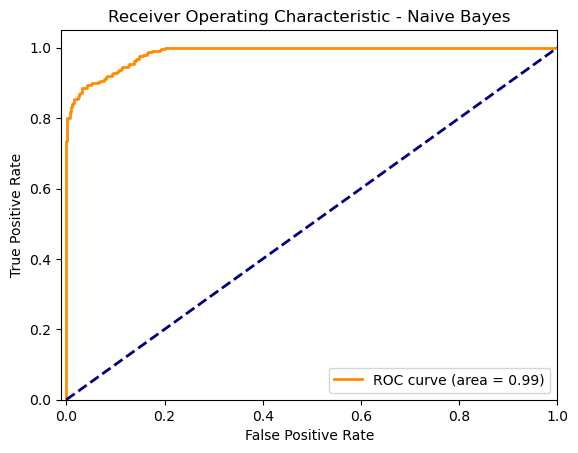


Baseline accuracy (majority class): 0.580

BernoulliNB with alpha=0: Accuracy=0.928
Confusion Matrix:
[[353  67]
 [  5 575]]
Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      0.84      0.91       420
        Spam       0.90      0.99      0.94       580

    accuracy                           0.93      1000
   macro avg       0.94      0.92      0.92      1000
weighted avg       0.93      0.93      0.93      1000


BernoulliNB with alpha=0.01: Accuracy=0.928
Confusion Matrix:
[[353  67]
 [  5 575]]
Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      0.84      0.91       420
        Spam       0.90      0.99      0.94       580

    accuracy                           0.93      1000
   macro avg       0.94      0.92      0.92      1000
weighted avg       0.93      0.93      0.93      1000



/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/sklearn/naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/sklearn/naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(



BernoulliNB with alpha=0.1: Accuracy=0.928
Confusion Matrix:
[[353  67]
 [  5 575]]
Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      0.84      0.91       420
        Spam       0.90      0.99      0.94       580

    accuracy                           0.93      1000
   macro avg       0.94      0.92      0.92      1000
weighted avg       0.93      0.93      0.93      1000


BernoulliNB with alpha=1: Accuracy=0.927
Confusion Matrix:
[[352  68]
 [  5 575]]
Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      0.84      0.91       420
        Spam       0.89      0.99      0.94       580

    accuracy                           0.93      1000
   macro avg       0.94      0.91      0.92      1000
weighted avg       0.93      0.93      0.93      1000


BernoulliNB with alpha=10: Accuracy=0.922
Confusion Matrix:
[[347  73]
 [  5 575]]
Classification Report:
              precision  

In [213]:
import numpy as np
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.naive_bayes import BernoulliNB

# Data Loading and Preprocessing
def data_loader():
    with open('train', 'r') as file:
        train_data = file.read().split('\n')[:-1]
    with open('test', 'r') as file:
        test_data = file.read().split('\n')[:-1]
    return train_data, test_data

def parser(datum):
    email_addr, label, words = datum.split(' ', 2)
    words = words.split()
    word_dict = {words[i]: int(words[i+1]) for i in range(0, len(words), 2)}
    label = 1 if label == 'spam' else 0
    return label, word_dict

def data_preprocessing(train_data, test_data):
    y_train = np.zeros(len(train_data))
    y_test = np.zeros(len(test_data))
    x_train = []
    x_test = []
    for i, datum in enumerate(train_data):
        label, word_dict = parser(datum)
        y_train[i] = label
        x_train.append(word_dict)
    for i, datum in enumerate(test_data):
        label, word_dict = parser(datum)
        y_test[i] = label
        x_test.append(word_dict)
    return x_train, y_train, x_test, y_test

# Naive Bayes Implementation
def compute_empirical_pmf_y(y_train):
    p_spam = np.mean(y_train)
    p_ham = 1 - p_spam
    return p_spam, p_ham

def m_estimation_conditional_probability(x_train_frt, y_train, m):
    idx_spam = np.where(y_train == 1)[0]
    idx_ham = np.where(y_train == 0)[0]
    n_spam = len(idx_spam)
    n_ham = len(idx_ham)
    p_prior = np.sum(x_train_frt, axis=0) / x_train_frt.shape[0]
    k_spam = np.sum(x_train_frt[idx_spam], axis=0)
    k_ham = np.sum(x_train_frt[idx_ham], axis=0)
    p_on_spam_m = (k_spam + m * p_prior) / (n_spam + m)
    p_on_ham_m = (k_ham + m * p_prior) / (n_ham + m)
    return p_on_spam_m, p_on_ham_m

def log_estimated_probability(p_spam, p_ham, p_on_spam_m, p_on_ham_m, x_frts):
    epsilon = 1e-10
    log_p_spam_prior = np.log(p_spam + epsilon)
    log_p_ham_prior = np.log(p_ham + epsilon)
    log_p_on_spam_m = np.log(p_on_spam_m + epsilon)
    log_one_minus_p_on_spam_m = np.log(1 - p_on_spam_m + epsilon)
    log_p_on_ham_m = np.log(p_on_ham_m + epsilon)
    log_one_minus_p_on_ham_m = np.log(1 - p_on_ham_m + epsilon)
    log_p_spam = log_p_spam_prior + x_frts @ log_p_on_spam_m + (1 - x_frts) @ log_one_minus_p_on_spam_m
    log_p_ham = log_p_ham_prior + x_frts @ log_p_on_ham_m + (1 - x_frts) @ log_one_minus_p_on_ham_m
    return log_p_spam, log_p_ham

def plot_roc_curve(log_p_spam, log_p_ham, y_test):
    score = log_p_spam - log_p_ham
    score = np.clip(score, -700, 700)
    fpr, tpr, thresholds = roc_curve(y_test, score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Naive Bayes')
    plt.legend(loc="lower right")
    plt.show()

def evaluate_model(y_test, y_pred, log_p_spam, log_p_ham):
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.3f}")
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    cr = classification_report(y_test, y_pred, target_names=['Ham', 'Spam'])
    print("Classification Report:")
    print(cr)
    plot_roc_curve(log_p_spam, log_p_ham, y_test)

def pipeline(x_train_frt, y_train, x_test_frt, y_test, m):
    p_spam, p_ham = compute_empirical_pmf_y(y_train)
    p_on_spam_m, p_on_ham_m = m_estimation_conditional_probability(x_train_frt, y_train, m)
    log_p_spam, log_p_ham = log_estimated_probability(p_spam, p_ham, p_on_spam_m, p_on_ham_m, x_test_frt)
    test_pred = (log_p_spam > log_p_ham)
    evaluate_model(y_test, test_pred, log_p_spam, log_p_ham)

# Load and preprocess data
train_data, test_data = data_loader()
x_train, y_train, x_test, y_test = data_preprocessing(train_data, test_data)

# Feature Extraction
vectorizer = DictVectorizer(sparse=False)
x_train_frt = vectorizer.fit_transform(x_train)
x_test_frt = vectorizer.transform(x_test)

# Binarization
x_train_frt = (x_train_frt > 0).astype(int)
x_test_frt = (x_test_frt > 0).astype(int)

# Verify Binarization
print("\nAre all training features binary?", np.all((x_train_frt == 0) | (x_train_frt == 1)))
print("Are all testing features binary?", np.all((x_test_frt == 0) | (x_test_frt == 1)))

# Run pipeline for different m values
m_grid = [0, 0.01, 0.1, 1, 10, 100, 1000]
for m in m_grid:
    pipeline(x_train_frt, y_train, x_test_frt, y_test, m)

# Baseline accuracy (always predict the majority class)
majority_class = Counter(y_train).most_common(1)[0][0]
baseline_pred = np.full_like(y_test, fill_value=majority_class)
baseline_accuracy = accuracy_score(y_test, baseline_pred)
print(f"\nBaseline accuracy (majority class): {baseline_accuracy:.3f}")

# Compare with scikit-learn's BernoulliNB
def compare_with_sklearn(x_train_frt, y_train, x_test_frt, y_test, m_grid):
    for m in m_grid:
        clf = BernoulliNB(alpha=m, binarize=None)  # binarize=None since data is already binary
        clf.fit(x_train_frt, y_train)
        y_pred = clf.predict(x_test_frt)
        acc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        cr = classification_report(y_test, y_pred, target_names=['Ham', 'Spam'])
        print(f"\nBernoulliNB with alpha={m}: Accuracy={acc:.3f}")
        print("Confusion Matrix:")
        print(cm)
        print("Classification Report:")
        print(cr)

compare_with_sklearn(x_train_frt, y_train, x_test_frt, y_test, m_grid)
